In [50]:
using FFTW, LinearAlgebra

In [1]:
include("jim.jl")
using PyCall, Libdl
Libdl.dlopen(ENV["HOME"]*"/.local/lib/python3.6/site-packages/llvmlite/binding/libllvmlite.so",
    Libdl.RTLD_DEEPBIND);

In [2]:
np = pyimport("numpy")

sp = pyimport("sigpy")
mr = pyimport("sigpy.mri")
pl = pyimport("sigpy.plot")

pushfirst!(PyVector(pyimport("sys")."path"), "")
dd = pyimport("python.download_dataset")
gr = pyimport("python.gridding_recon")

device = 0;

In [3]:
dd.download_dce_dataset()

ksp = np.load("data/dce/ksp.npy")
coord = np.load("data/dce/coord.npy")
dcf = np.load("data/dce/dcf.npy");

In [4]:
size(ksp)

(12, 41861, 711)

In [5]:
num_ro = 100  # number of readout points
ksp = ksp[:, :, 1:num_ro]
coord = coord[:, 1:num_ro, :]
dcf = dcf[:, 1:num_ro];

In [6]:
include("SigPy.jl")

Main.SigPy

In [39]:
""" Gridding reconstruction.

Args:
    ksp (array): k-space measurements of shape (C, num_tr, num_ro), where
        C is the number of channels,
        num_tr is the number of TRs, and
        num_ro is the readout points.
    coord (array): k-space coordinates of shape (num_tr, num_ro, D), where
        D is the number of spatial dimensions.
    dcf (array): density compensation factor of shape (num_tr, num_ro).
    mps (array): sensitivity maps of shape (C, N_D, ..., N_1) or constant 1, where
        (N_D, ..., N_1) represents the image shape.
    T (int): number of frames.

Returns:
    img (array): image of shape (T, N_D, ..., N_1).
"""
function gridding_recon(ksp, coord, dcf, mps=1, T=1)
    # calculate size parameters
    C, num_tr, num_ro = size(ksp)
    _, _, D = size(coord)
    tr_per_frame = num_tr ÷ T
    points_per_frame = tr_per_frame * num_ro    
    img_shape = SigPy.estimate_shape(coord)
    
    # reshape arrays for easier indexing
    ksp = permutedims(reshape(ksp, C, points_per_frame, T), (1, 3, 2))
    coord = permutedims(reshape(coord, points_per_frame, T, D), (2, 1, 3))
    dcf = permutedims(reshape(dcf, 1, points_per_frame, T), (1, 3, 2))
    
    # initialize image with zeros
    #img = zeros(Float32, T, img_shape...)
    #ksp_dcf = Array{ComplexF32}(undef, points_per_frame)
    
    # reconstruct!
    #for t in 1:T, c in 1:C
    #    ksp_dcf .= @views ksp[c, :, t] .* dcf[:, t]
    #    img[t, :, :, :] .+= abs2.(sp.nufft_adjoint(ksp_dcf, coord))
    #end
    img = abs2.(SigPy.nufft_adjoint(ksp .* dcf, coord))
    
    return sqrt.(sum(img, dims=1))
end

gridding_recon

In [23]:
FFTW.set_num_threads(40)

In [40]:
@time grd_julia = gridding_recon(ksp, coord, dcf);

  4.581551 seconds (174.83 k allocations: 1.391 GiB, 4.63% gc time)


In [42]:
@time grd_python = gr.gridding_recon(ksp, coord, dcf, device=-1);

 86.187806 seconds (87 allocations: 267.609 KiB)


In [51]:
print("absolute error: ", norm(grd_julia - grd_python, Inf), "\n",
    "relative error: ", norm((grd_julia - grd_python) ./ grd_python, Inf))

absolute error: 6.191991e-5
relative error: 0.03241437

In [55]:
function visualize(img; c=nothing, t=nothing)
    if t isa Nothing
        jim(permutedims(img[1,:,end:-1:1,end:-1:1], (3,2,1)), abswarn=false)
    else
        jim(permutedims(img[:,t,end:-1:1,end:-1:1], (3,2,1)), abswarn=false)
    end
end

visualize (generic function with 1 method)

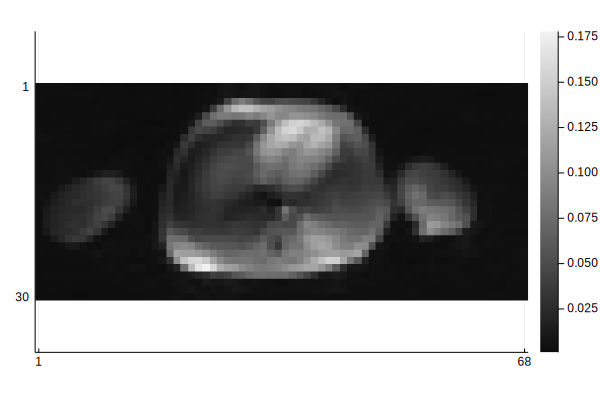

In [56]:
visualize(grd_julia, t=16)

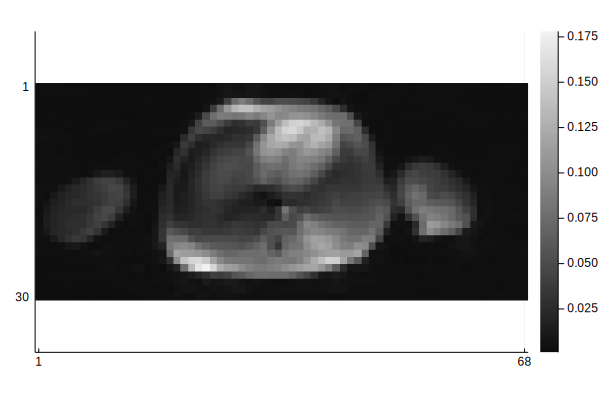

In [57]:
visualize(grd_python, t=16)

In [10]:
mps = np.load("data/dce/mps.npy");
#mps = mr.app.JsenseRecon(ksp, coord=coord, weights=dcf, device=device).run()
#np.save("data/dce/mps.npy", mps)

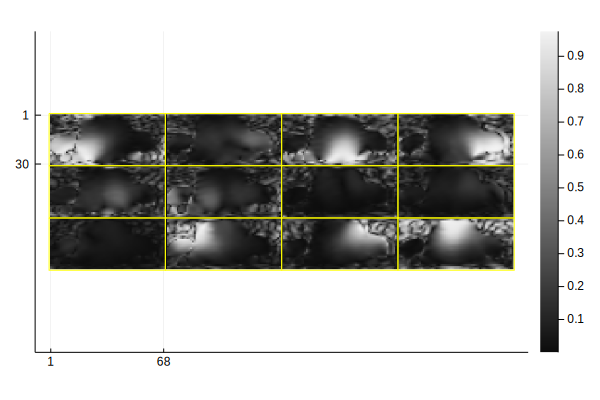

In [11]:
visualize(mps, t=16)